<a href="https://colab.research.google.com/github/DmitryKostin/data-analysis-projects/blob/main/02_students_outflow_project/students_outflow_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование оттока студентов с онлайн-курса на платформе Stepik

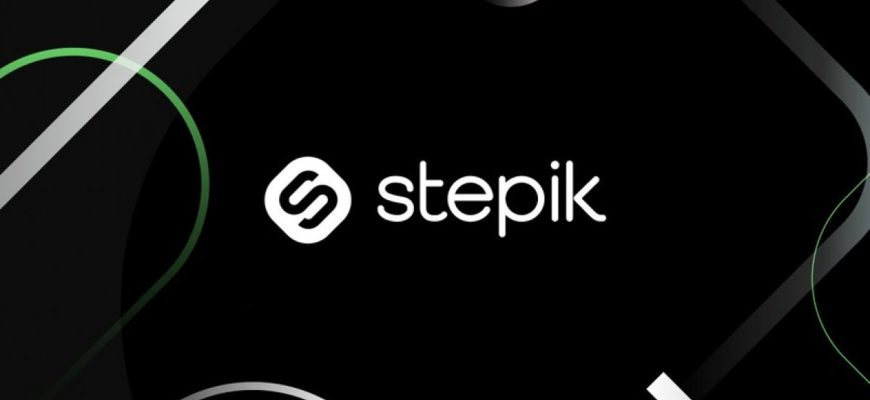

## Описание проекта <a class='anchor' id='description'></a>

**Цель проекта** - предсказать, бросит ли студент учебу на онлайн-курсе на основе его активности в первые 3 дня пребывания на курсе.

**Исходные данные** - данные об активности студентов курса [«Анализ данных в R»](https://stepik.org/course/129/promo) на платформе Stepik с 15 июня 2015 г. по 19 мая 2018 г.

Исследование основано на материалах курса [«Введение в Data Science и машинное обучение»](https://stepik.org/course/4852/promo) от Анатолия Карпова и [Bioinformatics Institute](https://stepik.org/org/bioinf). Соревнования участников по выбору наилучшей модели предсказания также более известны как [Stepik ML Contest](https://stepik.org/lesson/226979/step/1?unit=199528), который проводился в мае 2019 года по окончанию данного курса на альтернативных данных. Результаты соревнований представлены [здесь](https://stepik.org/lesson/226979/step/2?unit=199528).

В данном проекте используются базовые ML-модели:
* Logistic Regression
* Linear Regression
* Decision Tree Classifier
* KNeighbors Classifier
* Random Forrest

**Содержание** <a class='anchor' id='table_of_contents'></a>

* [Описание проекта](#description)
* [Описание данных](#data)
* [Шаг 1. Загрузка данных и изучение общей информации](#step_1)
* [Шаг 2. Предобработка данных](#step_2)
* [Шаг 3. Построение моделей машинного обучения](#step_3)
* [Шаг 4. Агрегация метрик и оценка качества моделей](#step_4)
* [Выводы](#final)

## Описание данных <a class='anchor' id='data'></a>

Датасет `event_data_train.csv` содержит следующие данные:
- `step_id` - id стэпа;
- `user_id` - анонимизированный id юзера;
- `timestamp` - время наступления события в формате unix date;
- `action` - событие, возможные значения: 
    - **discovered** - пользователь перешел на стэп;
    - **viewed** - просмотр шага;
    - **started_attempt** - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага;
    - **passed** - удачное решение практического шага.

Датасет `submissions_data_train.csv` содержит следующие данные:
- `step_id` - id степа;
- `timestamp` - время отправки решения в формате unix date;
- `submission_status` - статус решения:
    - **correct** - верный ответ;
    - **wrong** - неверный ответ;
- `user_id` - анонимизированный id пользователя.

## Шаг 1. Загрузка данных и изучение общей информации <a class='anchor' id='step_1'></a>

Загрузим необходимые для проекта библиотеки и датасеты.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize': (10, 7)}) 

In [2]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data):
    display(data.head())
    print('Число дубликатов:', data.duplicated().sum())
    print()
    data.info()

In [3]:
# функция для подсчета доли пропусков
def get_na(data):
    na_info = (
        pd.DataFrame(data.isna().mean())
        .rename(columns={0: 'NaN'})
        .style
        .set_caption('Доля пропусков')
        .background_gradient('coolwarm')
        .format('{:.2%}')
        )
    return na_info

In [4]:
events_data = pd.read_csv('event_data_train.csv')
submissions_data = pd.read_csv('submissions_data_train.csv')

#### Данные о событиях на курсе `events_data`

Посмотрим общую информацию и примеры данных.

In [5]:
get_info(events_data)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Число дубликатов: 2333

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480703 entries, 0 to 3480702
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   step_id    int64 
 1   timestamp  int64 
 2   action     object
 3   user_id    int64 
dtypes: int64(3), object(1)
memory usage: 106.2+ MB


In [6]:
get_na(events_data)

,NaN
step_id,0.00%
timestamp,0.00%
action,0.00%
user_id,0.00%


Рассмотрим данные о действиях, которые совершают студенты со степами:
- **step_id** - id стэпа;
- **user_id** - анонимизированный id юзера;
- **timestamp** - время наступления события в формате unix date;
- **action** - событие, возможные значения: 
    - **discovered** - пользователь перешел на стэп;
    - **viewed** - просмотр шага;
    - **started_attempt** - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага;
    - **passed** - удачное решение практического шага.

Узнаем уникальные значения пользователей, степов и действий, которые могут совершать пользователи.

In [7]:
print('Количество уникальных пользователей:', events_data.user_id.nunique())
print('Количество уникальных степов:', events_data.step_id.nunique())
print('Уникальные действия, совершаемые пользователем:', events_data.action.unique())

Количество уникальных пользователей: 19234
Количество уникальных степов: 198
Уникальные действия, совершаемые пользователем: ['viewed' 'passed' 'discovered' 'started_attempt']


#### Данные о времени и статусе решений практических заданий `submission_data`

In [8]:
get_info(submissions_data)

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Число дубликатов: 107

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509104 entries, 0 to 509103
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   step_id            509104 non-null  int64 
 1   timestamp          509104 non-null  int64 
 2   submission_status  509104 non-null  object
 3   user_id            509104 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 15.5+ MB


In [9]:
get_na(submissions_data)

,NaN
step_id,0.00%
timestamp,0.00%
submission_status,0.00%
user_id,0.00%


Рассмотрим данные о времени и статусе решений практических заданий:
- **step_id** - id степа;
- **timestamp** - время отправки решения в формате unix date;
- **submission_status** - статус решения:
    - **correct** - верный ответ;
    - **wrong** - неверный ответ;
- **user_id** - анонимизированный id пользователя.

[Назад к содержанию](#table_of_contents)

## Шаг 2. Предобработка данных <a class='anchor' id='step_2'></a>

### Предобработка `events_data`

Столбец `timestamp` хранит в себе временные данные в формате *unix time*, которые записываются в секундах. Для удобства дальнейших вычислений добавим столбец `date`, в котором конвертируем формат *timestamp* в обычные даты.

In [10]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35
...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30


Рассмотрим минимальное и максимальное значения для столбца `date`, которые будут являться началом и концом исследуемого периода.

In [11]:
print('Наиболее ранняя дата:', events_data.date.min())
print('Наиболее поздняя дата:', events_data.date.max())

Наиболее ранняя дата: 2015-06-15 04:00:48
Наиболее поздняя дата: 2018-05-19 23:33:31


Как видим, исследуемый период составляет около 3-х лет и охватывает события курса начиная с 15 июня 2015 г. по 19 мая 2018 г.

Для удобства добавим столбец `day` с календарными датами, не включающими суточное время.

In [12]:
events_data['day'] = events_data.date.dt.date
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


Построим график с посещением уникальных пользователей, которые совершали какие-либо действия на курсе.

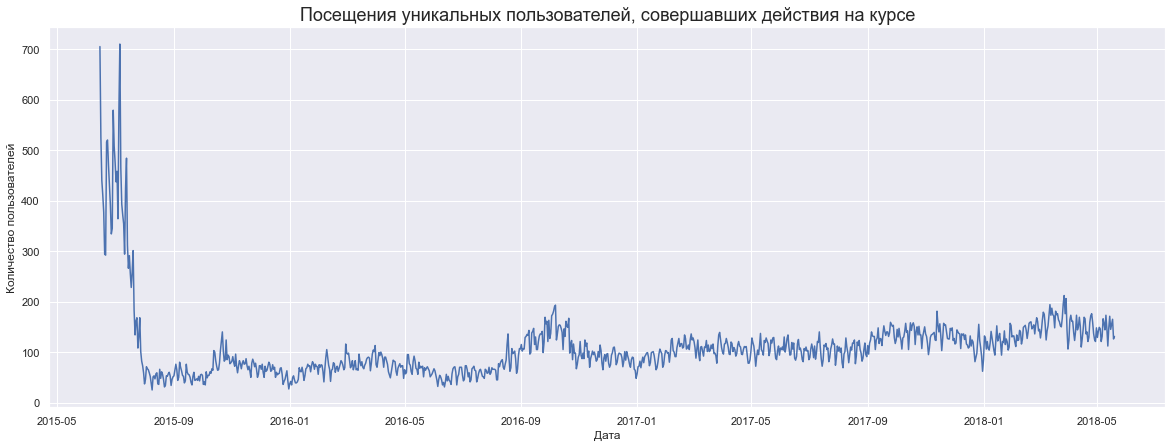

In [13]:
events_data.groupby('day').user_id.nunique().plot(figsize=(20,7))
plt.title('Посещения уникальных пользователей, совершавших действия на курсе', fontsize=18)
plt.xlabel('Дата')
plt.ylabel('Количество пользователей');

Как видно из графика, наибольшей популярностью курс пользовался в первые 2-3 месяца, после чего активность студентов значительно упала. Далее, в течение всех трех лет наметился слабый тренд на приток все большего количества новых пользователей. После спада ажиотажа максимальные пики активности приходились на конец 2016 года и весну 2018 года.

Расскроем столбец `action` с помощью изменения формата таблицы - сгруппируем данные по пользователям и подсчитаем количество их уникальных действий.

In [14]:
events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


На основе полученного датафрейма построим гистограмму с распределением пользователей по пройденным степам.

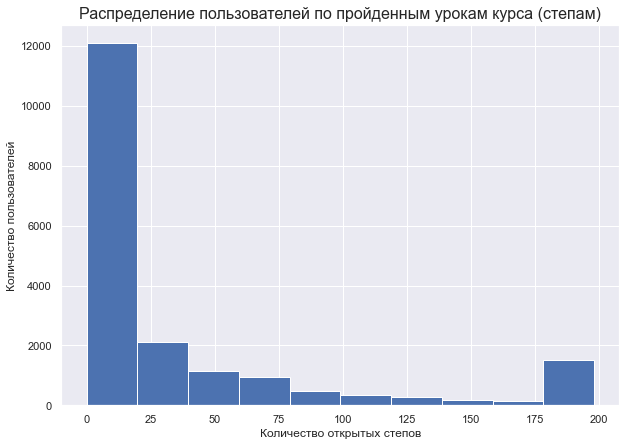

In [15]:
events_data.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).discovered.hist()
plt.xlabel('Количество открытых степов')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по пройденным урокам курса (степам)', fontsize=16);

Наибольшее число пользователей открыло (событие *discovered* из столбца `action`) лишь около 20 уроков из 198 возможных. На конце гистограммы также можно заметить существенное количество пользователей (около 1,5 тыс. человек из 19234), дошедших до конца курса.

[Назад к содержанию](#table_of_contents)

### Предобработка `submissions_data`

На данном этапе решим следующие задачи:
- преобразование датафрейма и добавление новых столбцов;
- вычисление промежутков между входами на курс каждого пользователя (`gap_data`);
- определить пороговое значение в днях, после которого студент бросает учебу на курсе.

Выполним аналогичное преобразование столбца `timestamp` и добавим новые столбцы `day` и `date` с удобным форматом времени.

In [16]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


Создадим датафрейм users_scores, в котором более детально раскроем данные о результатах решений задач студентами.

In [17]:
users_scores = submissions_data.pivot_table(index='user_id',
                                            columns='submission_status',
                                            values='step_id',
                                            aggfunc='count',
                                            fill_value=0).reset_index()

users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


Теперь по каждому пользователю в столбце `correct` будет храниться количество его верных ответов, а в столбце `wrong` - неверных.

Следующей задачей является поиск перерывов в учебе пользователей - промежуток между входами на курс и онлайн активностью.
Для этого отберем все уникальные дни, в который каждый пользователь заходил на курс.

In [18]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230
...,...,...,...
3480298,364,2018-05-19,1526762223
3480329,22851,2018-05-19,1526762629
3480333,943,2018-05-19,1526762664
3480669,26659,2018-05-19,1526770439


Соберем все значения с уникальными значениями `timestamp` для пользователей в отдельную серию.

In [19]:
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list)

user_id
1                                             [1472827464]
2                                 [1514383364, 1519226966]
3        [1434358476, 1441257725, 1441440209, 144153391...
5                                 [1466156809, 1499859621]
7                                             [1521634660]
                               ...                        
26790     [1451484016, 1451722241, 1452616205, 1517495853]
26793                                         [1510225031]
26794    [1495287049, 1495373177, 1495509936, 149560483...
26797                             [1508425316, 1509993306]
26798                                         [1520975763]
Name: timestamp, Length: 19234, dtype: object

Далее найдем разницу всех значений, выраженную в секундах, запишем ее в переменную `gap_data` и конвертируем ее в дни.

In [20]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
        .apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 60 * 60)
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

Получим серию с значениями разниц между двумя ближайшими входами в `timestamp` - **в днях** (разница между входами пользователя на курс).

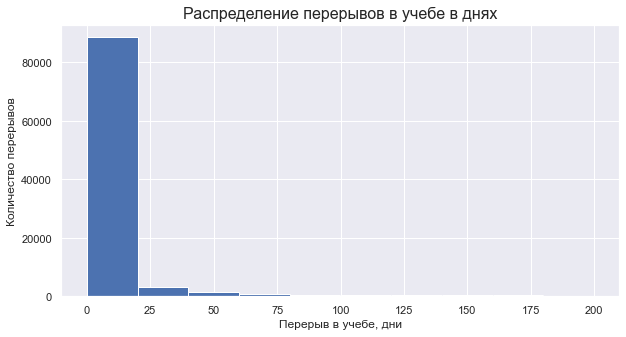

In [21]:
gap_data[gap_data < 200].hist(figsize=(10, 5))
plt.xlabel('Перерыв в учебе, дни')
plt.ylabel('Количество перерывов')
plt.title('Распределение перерывов в учебе в днях', fontsize=16);

Из всех перерывов в учебе, которые допускали все пользователи, подавляющая часть не превышает 20 дней. Посмотрим более детальную информацию.

In [22]:
gap_data.quantile(np.arange(0.85, 0.99, 0.01)).round(1)

0.85      9.3
0.86     10.6
0.87     12.0
0.88     13.7
0.89     15.5
0.90     18.3
0.91     22.1
0.92     27.5
0.93     34.8
0.94     44.9
0.95     59.8
0.96     82.1
0.97    120.8
0.98    179.2
0.99    294.6
dtype: float64

Исходя из представленного выше распределения можно сделать следующие выводы:
- Только 5% пользователей возвращаются на курс после перерыва в 2 месяца (59,76 дней);
- 95% пользователей не возвращаются после 2 месяцев отсутствия;
- 90% пользователей не возвращаются после 18 дней отсутствия; 
- 3% пользователей - возвращается к курсу после перерыва в 120 дней;
- 2% пользователей - возвращается к курсу после перерыва в 179 дней;
- 1% пользователей - возвращается к курсу после перерыва в 294 дня.

На основе оценки между 0.90 и 0.95 перцентилем выберем оптимальным пороговым значением период в **30 дней**: если человек не прошел курс до конца, т.е. не получил сертификат и отсутствовал более чем 30 дней - будем считать, что человек **бросил** курс.

Если человек отсутствовал 30 дней, но получил сертификат (прошел курс), он не будет считаться "бросившим".

[Назад к содержанию](#table_of_contents)

### Подготовка датафрейма `users_data` со сводными данными о пользователях 

На данном этапе решим следующие задачи:
- определим, кто из пользователей бросил курс, а кто - нет;
- соберем сводный датафрейм `users_data` с результатами учебы всех пользователей;
- проанализируем полученные данные.

Создадим датафрейм `users_data`, который будем постепенно наполнять детальными данными о пользователях.

Для начала внесем в него данные о максимальном значении `timestamp` для каждого пользователя - последний момент, когда студент заходил на курс. Нас интересует, правда ли, что максимальное значение `timestamp` больше, чем вычисленное пороговое значение в 30 дней.

In [23]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

users_data

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


Вычислим максимальный timestamp и убедимся, что он действительно является самым поздним в датафрейме.

In [24]:
now = events_data.timestamp.max() 
print(now)
events_data.tail(3)

1526772811


,step_id,timestamp,action,user_id,date,day
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


Как видим, событие, приходящееся на дату 19 мая 2018 г. (`2018-05-19`) имеет индекс строки `3480702`. Она является последней и имеет конечный `timestamp` - 1526772811.

Вычислим пороговое значение 30-ти дней, переведем его в секунды и запишем в переменную `drop_out_threshold`.

In [25]:
drop_out_threshold = 30 * 24 * 60 * 60
drop_out_threshold

2592000

Добавим в `users_data` столбец `is_gone_user`, в котором сравним время отсутствия студента на курсе с нашим пороговым значением 30 дней (`drop_out_threshold`).

In [26]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


Теперь, пометка `True` будет означать, что пользователь бросил курс, `False` - не бросил.

Выполним слияние с датафреймом `users_scores`, где находятся результаты о прохождении заданий. Ключом присоединения будет являться столбец `user_id`. Все пустые значения заполним нулями.


In [27]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0
19230,26793,1510225034,True,0.0,0.0
19231,26794,1512035039,True,33.0,9.0
19232,26797,1509995096,True,2.0,0.0


Теперь нашей задачей является сформировать аггрегированный датафрейм, в котором будут данные не только о результатах прохождения курса, но и сводка о всех действия каждого пользователя. Для этого вновь обратимся к датафрейму `events_data`, где хранятся данные об онлайн событиях на курсе. 

In [28]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Еще раз расскроем столбец `action` с помощью изменения формата таблицы - сгруппируем данные по пользователям и запишем его в переменную `users_events_data`. 

In [29]:
users_events_data = events_data.pivot_table(index='user_id', 
                                            columns='action', 
                                            values='step_id', 
                                            aggfunc='count', 
                                            fill_value=0).reset_index()
users_events_data

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


Теперь выполним присоединение датафреймов `users_data` и `users_events_data`. Таким образом получим сводный датафрейм о всех действиях и результатах каждого из пользователей.

In [30]:
users_data = users_data.merge(users_events_data, how='outer')
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9
19230,26793,1510225034,True,0.0,0.0,1,0,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180
19232,26797,1509995096,True,2.0,0.0,10,10,2,13


Теперь подсчитаем количество уникальных дней, проведенных пользователем на курсе и сохраним данные в датафрейм `users_days`.
Присоединим `users_days` к `users_data`.

In [31]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2


Проверим, что в процессе преобразований мы не потеряли данные о пользователях. Их количество должно быть 19 234 человек.

In [32]:
print('Количество пользователей в users_data:', users_data.user_id.nunique())
print('Количество пользователей в events_data:', events_data.user_id.nunique())

Количество пользователей в users_data: 19234
Количество пользователей в events_data: 19234


Завершая все преобразования, добавим в датафрейм `users_data` колонку `passed_course` - метку прошел ли пользователь курс.
Для этого отберем студентов, которые прошли более 170 степов (из 198).

In [33]:
users_data['passed_course'] = users_data.passed > 170
users_data

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,1.0,0.0,8,8,1,9,4,False
19230,26793,1510225034,True,0.0,0.0,1,0,1,1,1,False
19231,26794,1512035039,True,33.0,9.0,69,69,34,180,9,False
19232,26797,1509995096,True,2.0,0.0,10,10,2,13,2,False


Подводя итог, опишем полученный датафрейм `users_data`:
- *user_id* - id пользователя;
- *last_timestamp* - метка о последнем появлении на курсе;
- *is_gone_user* - бросил ли пользователь курс;
- *discovered* - количество открытых (начатых) степов (уроков/заданий);
- *passed* - кол-во пройденных степов;
- *started_attempt* - кол-во попыток пройти тот или иной степ;
- *viewed* - кол-во просмотренных степов (до конца);
- *day* - кол-во уникальных дней пребывания на курсе;
- *passed_course* - прошел ли пользователь курс до конца.

Проведем краткий анализ полученных сведений. Посмотрим, сколько студентов прошло курс.

In [34]:
display(users_data.groupby('passed_course').count())
display(users_data['passed_course'].value_counts(normalize=True))

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


False    0.925912
True     0.074088
Name: passed_course, dtype: float64

Как мы видим из данных:
- 17 809 чел. - не прошло курс (92,6%);
- 1 425 чел. - закончило курс (7,4%);

Всего: 19 234 чел.

Матрица парных корреляций в строке `passed_course` показывает достаточно предсказуемую и очевидную закономерность: чем больше у пользователя начатых, просмотренных уроков, попыток и верно решенных заданий, тем вероятнее, что он пройдет курс до конца.

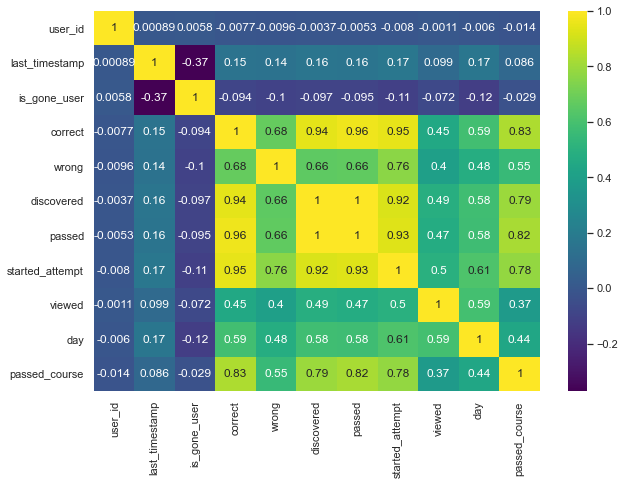

In [35]:
hm = sns.heatmap(users_data.corr(), cbar=True, annot=True, cmap='viridis')

Узнаем медианное значение дней, за которое студенты прошли курс и построим гистограмму распределения данного признака.

Медианное значение дней прохождения курса: 20.0


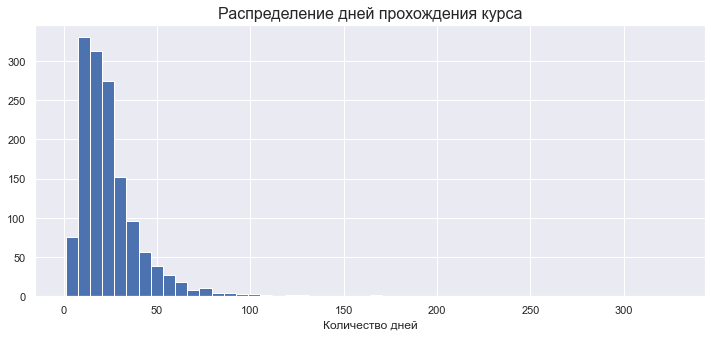

In [36]:
print('Медианное значение дней прохождения курса:', users_data[users_data.passed_course == True].day.median())
users_data[users_data.passed_course == True].day.hist(figsize=(12, 5), bins=50)
plt.title('Распределение дней прохождения курса', fontsize=16)
plt.xlabel('Количество дней');

[Назад к содержанию](#table_of_contents)

### Формирование выборки по исследуемому интервалу времени

На данном этапе решим следующие задачи:
- отобрать все события пользователя, произошедшие в первые 3 дня обучения из `events_data`;
- отобрать все результаты за первые 3 дня из `submissions_data`.

Теперь отберем все события, которые происходили с пользователем в его первые 3 дня на курсе (в датафрейме `events_data`). Для начала найдем самые ранние `timestamp` для всех пользователей. Они будут свидетельствовать о первом действии студентов на курсе.

In [37]:
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
        .rename({'timestamp': 'min_timestamp'}, axis=1)
user_min_time

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660
...,...,...
19229,26790,1451484016
19230,26793,1510225031
19231,26794,1495287049
19232,26797,1508425316


Добавим эту информацию в датафрейм `events_data`, где произведем фильтрацию событий первых 3-х дней курса.

In [38]:
events_data = events_data.merge(user_min_time, how='outer')
events_data_train = events_data.query("timestamp <= min_timestamp + 3 * 24 * 60 * 60")
events_data_train

,step_id,timestamp,action,user_id,date,day,min_timestamp
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434340848
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434340848
...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,1526762664
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,1526772750
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,1526772750


Из 3 480 703 событий, которые охватывают 3-летний промежуток, у нас осталось 1 014 985 событий, произошедшие с каждым пользователем в его первые 3 дня пребывания на курсе.

Сделаем аналогичное преобразование с датафреймом `submissions_data`. Добавим в него время первых степов, вычислим интервал от первых до последних и отберем действия первых 3-х дней.

In [39]:
submissions_data = submissions_data.merge(user_min_time, on='user_id', how='left')
submissions_data['users_time'] = submissions_data['timestamp'] - submissions_data['min_timestamp']
submissions_data_train = submissions_data[submissions_data.users_time <= 3 * 24 * 60 * 60]
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day,min_timestamp,users_time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,1434345977,3298
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,1434345977,2323
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434345977,2146
5,31976,1434348188,correct,15853,2015-06-15 06:03:08,2015-06-15,1434345977,2211
7,31977,1434347371,correct,15853,2015-06-15 05:49:31,2015-06-15,1434345977,1394
...,...,...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05,1501946660,299
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18,1503055287,4640
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25,1506347263,890
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06,1523035269,47


[Назад к содержанию](#table_of_contents)

### Подготовка данных для обучения модели

Создадим датафрейм `X`, который постепенно будем наполнять всей полученной информацией о трехдневной активности студентов курса. Сперва запишем данные о количестве дней каждого пользователя в столбце `days`.

In [40]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days'})
X

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


Далее, в столбце `steps_tried` запишем количество уникальных степов, которые студент попытался решить.

In [41]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})
X = X.merge(steps_tried, on='user_id', how='outer')
X

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


Добавим к датафрейму `X` данные о количестве верных и неверных решений из `submissions_data_train`.

In [42]:
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                                               columns='submission_status',
                                               values='step_id',
                                               aggfunc='count',
                                               fill_value=0).reset_index())
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


Также, добавим столбец `correct_ratio`, в который запишем соотношение верных и неверных ответов студента.

In [43]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)
X

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.000000
1,3,1,4,4,4,0.500000
2,8,1,11,9,21,0.300000
3,14,1,1,0,1,0.000000
4,16,3,23,23,27,0.460000
...,...,...,...,...,...,...
8908,26787,1,3,3,0,1.000000
8909,26790,1,1,1,0,1.000000
8910,26794,3,27,31,9,0.775000
8911,26797,1,2,2,0,1.000000


Добавим к датафрейму данные о начатых степах `viewed` и заполним нулями недостающие значения.

In [44]:
X = X.merge(events_data_train.pivot_table(index='user_id',
                                          columns='action',
                                          values='step_id',
                                          aggfunc='count',
                                          fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')
X = X.fillna(0)
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1
19230,26781,0.0,0.0,0.0,0.0,0.00,6
19231,26788,0.0,0.0,0.0,0.0,0.00,1
19232,26789,0.0,0.0,0.0,0.0,0.00,2


Из датафрейма `users_data` присоединим данные с id пользователей, отметкой о прохождении курса, а также с признаком того, что студент бросил учебу на курсе.

In [45]:
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


Далее, отфильтруем тех студентов, которые не являются ушедшими (`is_gone_user == False`), но и не закончили курс до конца (`passed_course == False`). Данное множество людей нам необходимо **исключить** из выборки - для этого поставим знак отрицания перед логическим выражением. 
После этого мы получим следующее множество студентов:
- либо человек уже прошел курс;
- либо человек бросил курс, оставив его непройденным.

In [46]:
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]
display(X)
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

Подсчитаем полученные значения - как мы видим, количество бросивших студентов - 16 560 из 17 985. 

`passed_course` - отвечает за признак, является ли студент бросившим курс. Сделаем ее целевой переменной `y`.


In [47]:
y = X.passed_course.map(int)

Теперь в датафрейме `X` мы можем избавиться от ненужных при обучении модели столбцов `passed_course` и `is_gone_user`.

Также переместим `user_id` в индекс датафрейма и удалим сам столбец.

In [48]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1


Подведем итог и опишем данные в полученном датафрейме:
- **days** - день пребывания студента на онлайн-курсе;
- **steps_tried** - количество попыток решить то или иное задание;
- **correct** - число верных ответов, решений;
- **wrong** - число неверных ответов, решений;
- **correct_ratio** - соотношение верных и неверных ответов, решений;
- **viewed** - количество открытых для просмотра степов.

Всего исследуется поведение 17 985 студентов.

[Назад к содержанию](#table_of_contents)

## Шаг 3. Построение моделей машинного обучения <a class='anchor' id='step_3'></a>

На данном этапе воспользуемся базовыми ML-моделями:
* Logistic Regression
* Linear Regression
* Decision Tree Classifier
* KNeighbors Classifier
* Random Forrest

Объявим фукцию `all_metrics`, которая будет рассчитывать все основные метрики модели и изображать их визуализации. На вход функции будет подаваться модель и тестовые данные. 

In [49]:
def all_metrics(model, X_test, y_test):
    observations = y_test
    prediction = model.predict(X_test)

    true_positive = np.logical_and(prediction, observations)
    false_positive = np.logical_and(prediction, np.logical_not(observations))
    true_negative = np.logical_and(np.logical_not(prediction), np.logical_not(observations))
    false_negative = np.logical_and(np.logical_not(prediction), observations)

    tp, fp, tn, fn = (x.sum() for x in (true_positive, false_positive, true_negative, false_negative))
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (recall * precision) / (recall + precision)

    print('True Positive: ', tp)
    print('False Positive: ', fp)
    print('True Negative: ', tn)
    print('False Negative: ', fn)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F1 score: ', f1_score)
    
    try:
        metrics.plot_roc_curve(model, X_test, y_test)
        metrics.plot_precision_recall_curve(model, X_test, y_test)
        metrics.plot_confusion_matrix(model, X_test, y_test)
    except:
        print('Невозможно построить визуализации')

### Logistic Regression

**Логистическая регрессия** (англ. *logit model*) - статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой. Эта регрессия выдаёт ответ в виде вероятности бинарного события (1 или 0). Логистическая регрессия применяется для прогнозирования вероятности возникновения некоторого события по значениям множества признаков.

In [50]:
logreg = LogisticRegressionCV(cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

logreg.fit(X_train, y_train)

print(logreg.score(X_test, y_test))
print(logreg.coef_)
print(logreg.intercept_)
print(cross_val_score(logreg, X_train, y_train, cv=4).mean())

0.926605504587156
[[ 6.09288349e-01 -3.90169896e-02  9.76827079e-02  5.52748971e-03
   9.75696250e-01 -9.51796214e-04]]
[-4.05640232]
0.9218098415346122


True Positive:  40
False Positive:  21
True Negative:  3293
False Negative:  243
Accuracy:  0.926605504587156
Precision:  0.6557377049180327
Recall:  0.1413427561837456
F1 score:  0.23255813953488375


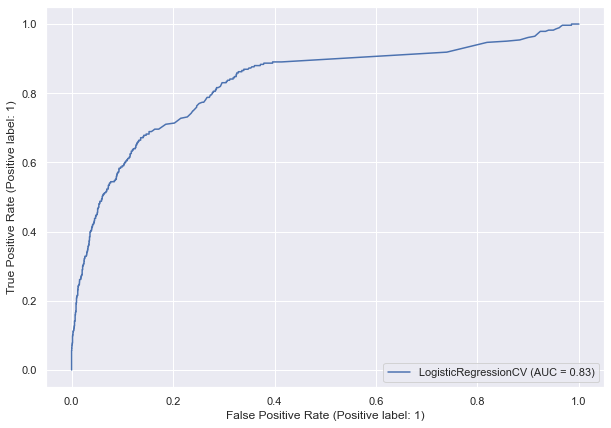

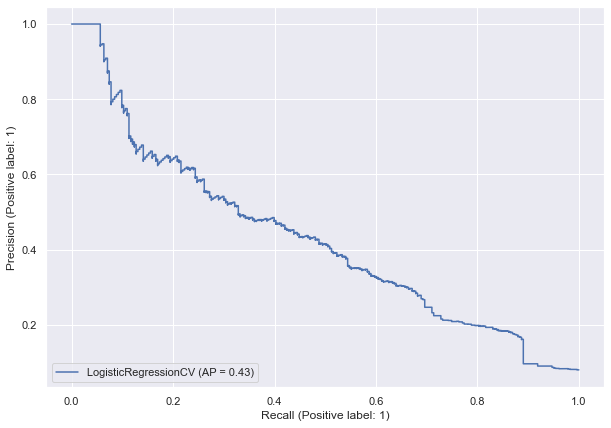

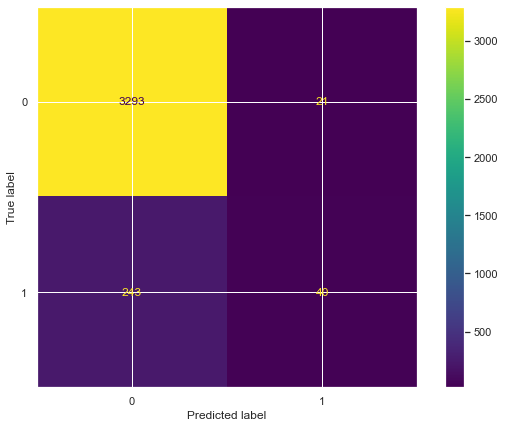

In [51]:
all_metrics(logreg, X_test, y_test)

[Назад к содержанию](#table_of_contents)

### Linear Regression

**Линейная регрессия** (англ. `Linear regression`) — используемая в статистике регрессионная модель зависимости одной (объясняемой, зависимой) переменной `y` от другой или нескольких других переменных (факторов, регрессоров, независимых переменных) `x` с линейной функцией зависимости.

Модель линейной регрессии является часто используемой и наиболее изученной в эконометрике. А именно изучены свойства оценок параметров, получаемых различными методами при предположениях о вероятностных характеристиках факторов, и случайных ошибок модели. Предельные (асимптотические) свойства оценок нелинейных моделей также выводятся исходя из аппроксимации последних линейными моделями. С эконометрической точки зрения более важное значение имеет линейность по параметрам, чем линейность по факторам модели.

In [52]:
linreg = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linreg.fit(X_train, y_train)

print(linreg.score(X_test, y_test))
print(linreg.coef_)
print(linreg.intercept_)
print(cross_val_score(linreg, X_train, y_train, cv=4).mean())

0.14289475439796784
[ 0.05548773 -0.01384836  0.02563763 -0.00042845 -0.01774932 -0.00011382]
0.011502117706470624
0.19319593457270584


In [53]:
all_metrics(linreg, X_test, y_test)

True Positive:  236
False Positive:  3361
True Negative:  0
False Negative:  0
Accuracy:  0.06561023074784543
Precision:  0.06561023074784543
Recall:  1.0
F1 score:  0.12314114270806158
Невозможно построить визуализации


[Назад к содержанию](#table_of_contents)

### Decision Tree Classifier

**Дерево принятия решений** (также называют деревом классификации или регрессионным деревом) — средство поддержки принятия решений, использующееся в машинном обучении, анализе данных и статистике. Структура дерева представляет собой «листья» и «ветки». На рёбрах («ветках») дерева решения записаны признаки, от которых зависит целевая функция, в «листьях» записаны значения целевой функции, а в остальных узлах — признаки, по которым различаются случаи. Чтобы классифицировать новый случай, надо спуститься по дереву до листа и выдать соответствующее значение.

Цель состоит в том, чтобы создать модель, которая предсказывает значение целевой переменной на основе нескольких переменных на входе. Каждый лист представляет собой значение целевой переменной, изменённой в ходе движения от корня по рёбрам дерева до листа. Каждый внутренний узел сопоставляется с одной из входных переменных.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt = DecisionTreeClassifier(criterion='entropy')
parameters = {'max_depth': range(3,6), 'max_leaf_nodes':range(6,15), 'min_samples_leaf': range(1,4),'min_samples_split':range(2,5)}
grid_search_cv_clf = GridSearchCV(dt, parameters, cv=4)
grid_search_cv_clf.fit(X_train, y_train)

model_dt = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model_dt, X_train, y_train, cv=4).mean())

{'max_depth': 5, 'max_leaf_nodes': 11, 'min_samples_leaf': 1, 'min_samples_split': 3} 0.9186127328329163


True Positive:  38
False Positive:  50
True Negative:  3311
False Negative:  198
Accuracy:  0.931053655824298
Precision:  0.4318181818181818
Recall:  0.16101694915254236
F1 score:  0.23456790123456792


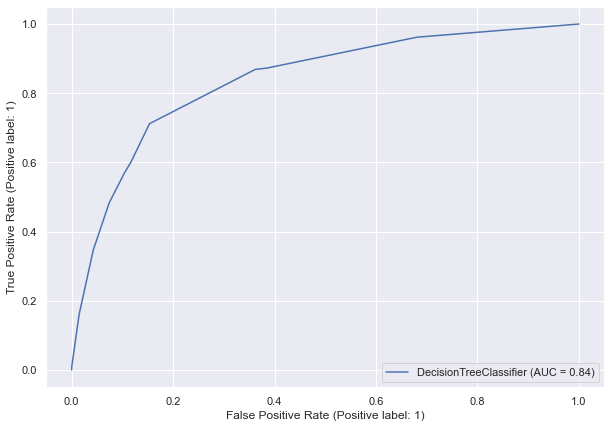

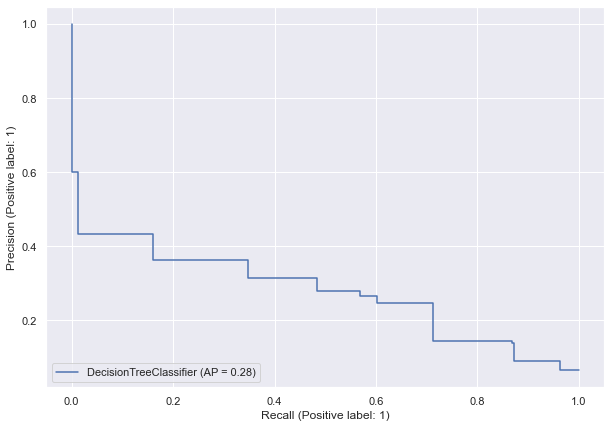

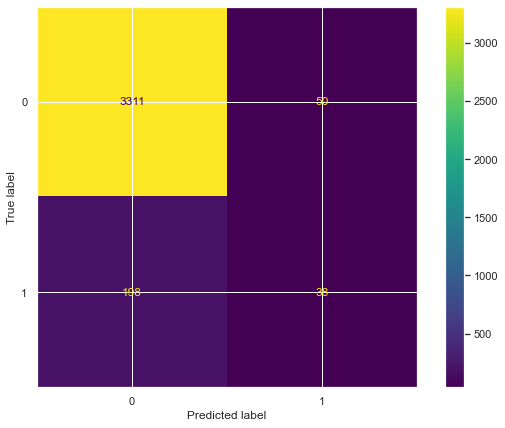

In [55]:
all_metrics(model_dt, X_test, y_test)

[Назад к содержанию](#table_of_contents)

### KNeighbors Classifier

**Метод k-ближайших соседей** (англ. `k-nearest neighbors algorithm`, `k-NN`) — метрический алгоритм для автоматической классификации объектов или регрессии.

В случае использования метода для классификации объект присваивается тому классу, который является наиболее распространённым среди `k` соседей данного элемента, классы которых уже известны. В случае использования метода для регрессии, объекту присваивается среднее значение по `k` ближайшим к нему объектам, значения которых уже известны.

Алгоритм может быть применим к выборкам с большим количеством атрибутов (многомерным). Для этого перед применением нужно определить функцию расстояния; классический вариант такой функции — евклидова метрика.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(15, 25), 'leaf_size': range(1, 7)}
grid_search_cv_clf = GridSearchCV(knn, parameters, cv=4, n_jobs=-1)
grid_search_cv_clf.fit(X_train, y_train)

model_knn = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model_knn, X_train, y_train, cv=4).mean())

{'leaf_size': 1, 'n_neighbors': 19} 0.9194467611898804


True Positive:  27
False Positive:  50
True Negative:  3311
False Negative:  209
Accuracy:  0.9279955518487628
Precision:  0.35064935064935066
Recall:  0.11440677966101695
F1 score:  0.17252396166134185


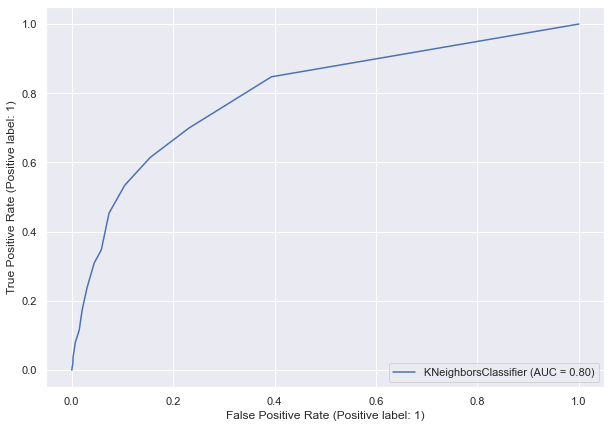

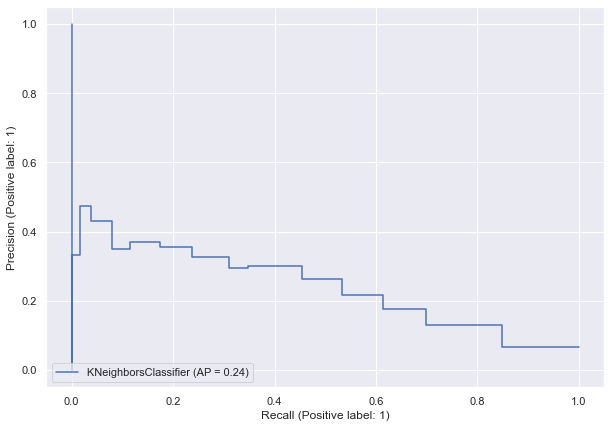

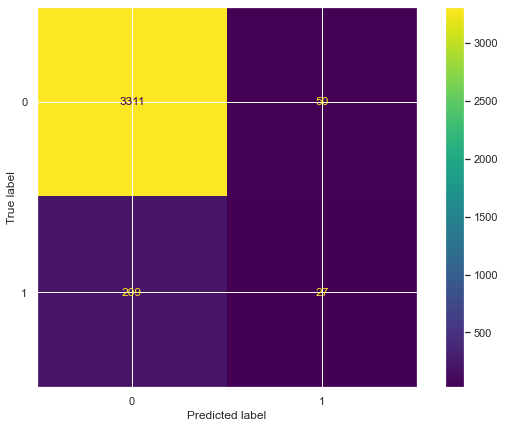

In [57]:
all_metrics(model_knn, X_test, y_test)

[Назад к содержанию](#table_of_contents)

### Random Forrest

**Метод случайного леса** (англ. `random forest`) — алгоритм машинного обучения, предложенный Лео Брейманом и Адель Катлер, заключающийся в использовании ансамбля решающих деревьев. Алгоритм сочетает в себе две основные идеи: метод бэггинга Бреймана и метод случайных подпространств, предложенный Тин Кам Хо. Алгоритм применяется для задач классификации, регрессии и кластеризации. Основная идея заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается хорошим.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_rf = RandomForestClassifier()
parametrs = {'n_estimators': [10, 20, 30], 'max_depth': [2, 5, 7, 10]}
grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(X_train, y_train)
grid_search_cv_clf.best_params_

best_clf = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(best_clf, X_train, y_train, cv=4).mean())

{'max_depth': 5, 'n_estimators': 30} 0.9205587989991659


True Positive:  22
False Positive:  20
True Negative:  3341
False Negative:  214
Accuracy:  0.9349457881567973
Precision:  0.5238095238095238
Recall:  0.09322033898305085
F1 score:  0.15827338129496404


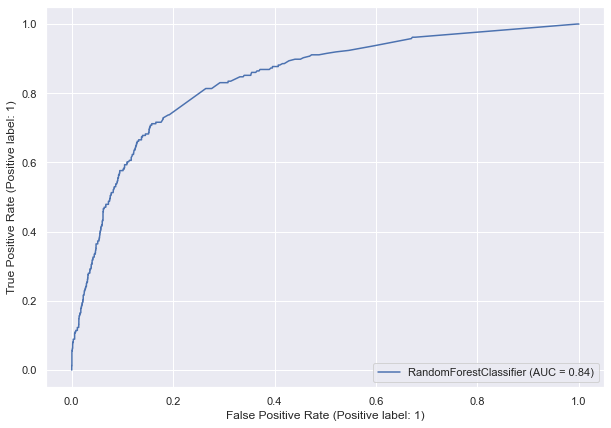

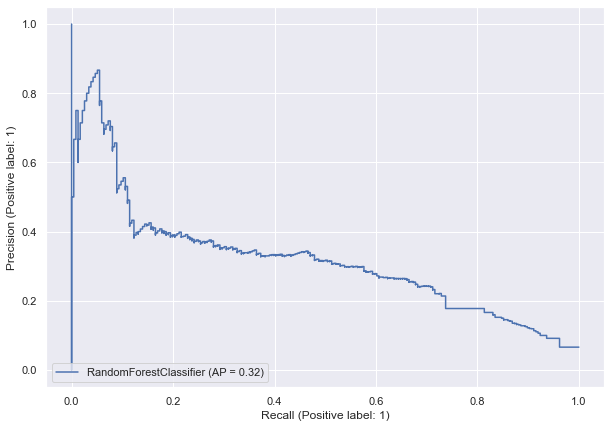

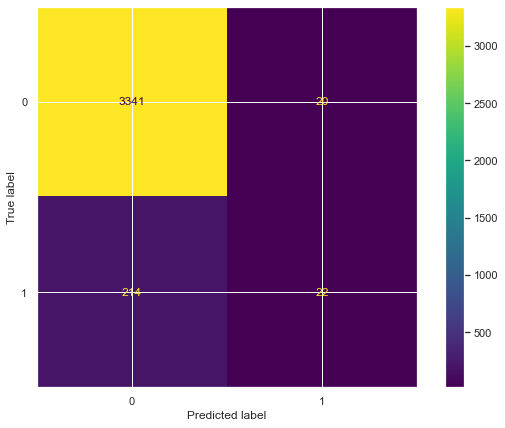

In [59]:
all_metrics(best_clf, X_test, y_test)

Рассмотрим распределение важности признаков.

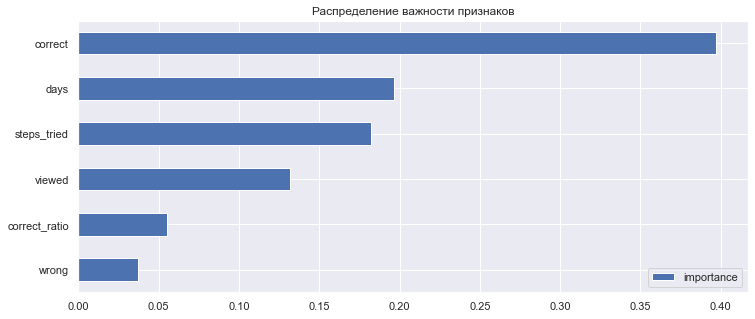

In [60]:
sns.set(rc={'figure.figsize': (12, 5)})

feature_importances = best_clf.feature_importances_
feature_importances_df = pd.DataFrame(best_clf.feature_importances_, index=X.columns, columns=['importance'])
feature_importances_df.sort_values('importance').plot(kind='barh', figsize=(12, 5))
plt.title('Распределение важности признаков');

In [61]:
feature_importances_df.sort_values('importance', ascending=False)

,importance
correct,0.397101
days,0.196812
steps_tried,0.182026
viewed,0.132110
correct_ratio,0.055093
wrong,0.036857


Наиболее весомым признаком является количество попыток студента - `steps_tried`.

[Назад к содержанию](#table_of_contents)

## Шаг 4. Агрегация метрик и оценка качества моделей <a class='anchor' id='step_4'></a>

Объявим функцию `metrics_to_dataframe`, собирающую все метрики модели в единую `pd.Series`.

In [62]:
def metrics_to_dataframe(model, X_test, y_test):
    observations = y_test
    prediction = model.predict(X_test)

    true_positive = np.logical_and(prediction, observations)
    false_positive = np.logical_and(prediction, np.logical_not(observations))
    true_negative = np.logical_and(np.logical_not(prediction), np.logical_not(observations))
    false_negative = np.logical_and(np.logical_not(prediction), observations)

    tp, fp, tn, fn = (x.sum() for x in (true_positive, false_positive, true_negative, false_negative))
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (recall * precision) / (recall + precision)

    return pd.Series([tp, fp, tn, fn, accuracy, precision, recall, f1_score])

Соберем метрики всех моделей в единый сводный датафрейм `metrics_data`.

In [63]:
names = ['True Positive', 'False Positive', 'True Negative', 'False Negative', 'Accuracy', 'Precision', 'Recall', 'F1 score']

metrics_data = pd.DataFrame()                                  

metrics_data['Random Forrest'] = metrics_to_dataframe(best_clf, X_test, y_test)
metrics_data['Logistic Regression'] = metrics_to_dataframe(logreg, X_test, y_test)
metrics_data['Linear Regression'] = metrics_to_dataframe(linreg, X_test, y_test)
metrics_data['Decision Tree'] = metrics_to_dataframe(model_dt, X_test, y_test)
metrics_data['KNeighbors'] = metrics_to_dataframe(model_knn, X_test, y_test)

metrics_data.index = names
metrics_data = metrics_data.round(2)

metrics_data

,Random Forrest,Logistic Regression,Linear Regression,Decision Tree,KNeighbors
True Positive,22.00,33.00,236.00,38.00,27.00
False Positive,20.00,39.00,3361.00,50.00,50.00
True Negative,3341.00,3322.00,0.00,3311.00,3311.00
False Negative,214.00,203.00,0.00,198.00,209.00
Accuracy,0.93,0.93,0.07,0.93,0.93
Precision,0.52,0.46,0.07,0.43,0.35
Recall,0.09,0.14,1.00,0.16,0.11
F1 score,0.16,0.21,0.12,0.23,0.17


## Выводы <a class='anchor' id='final'></a>

`Accuracy` — это показатель, который описывает общую точность предсказания модели по всем классам. Это особенно полезно, когда каждый класс одинаково важен. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству.

Все модели показали высокий `accuracy` (0.93) за исключение линейной регрессии (0.07).

`Precision` представляет собой отношение числа семплов, верно классифицированных как Positive, к общему числу выборок с меткой Positive (распознанных правильно и неправильно). Precision измеряет точность модели при определении класса Positive.

Наиболее высокий `precision` у модели `Random Forrest` - 0.52.

`Recall` рассчитывается как отношение числа Positive выборок, корректно классифицированных как Positive, к общему количеству Positive семплов. `Recall` измеряет способность модели обнаруживать выборки, относящиеся к классу Positive. Чем выше `recall`, тем больше Positive семплов было найдено.

`Recall` заботится только о том, как классифицируются Positive выборки. Эта метрика не зависит от того, как предсказываются Negative семплы, в отличие от `precision`. Когда модель верно классифицирует все Positive выборки, `recall` будет 100%, даже если все представители класса Negative были ошибочно определены как Positive.

Наиболее адекватный `recall` по сравнению с другими у модели `Decision Tree` - 0.16

`F1−score` - отношение удвоенного произведения `precision` и `recall` к их сумме. Чем выше метрика, тем лучше модель.

Наилучшим `F1-score` обладает модель `Decision Tree` - данная модель показала лучшие результаты по ряду метрик.

[Назад к содержанию](#table_of_contents)